# Resampling methods for model evaluation and attribute selection



In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt     

## Data preprocessing

In [2]:

data_path = "data/communities.data"
data = pd.read_csv(data_path, header=None, na_values=['?'])

# Reading attribute names from the .names file
def load_attribute_names(names_path):
    attribute_names = []
    with open(names_path, 'r') as f:
        for line in f:
            if line.startswith('@attribute'):
                attribute_name = line.split()[1]
                attribute_names.append(attribute_name)
    return attribute_names

names_path = "data/communities.names"
attribute_names = load_attribute_names(names_path)

data.columns = attribute_names

print(data.head())

# Number of Instances: 1994
# Number of Attributes: 128


   state  county  community        communityname  fold  population  \
0      8     NaN        NaN         Lakewoodcity     1        0.19   
1     53     NaN        NaN          Tukwilacity     1        0.00   
2     24     NaN        NaN         Aberdeentown     1        0.00   
3     34     5.0    81440.0  Willingborotownship     1        0.04   
4     42    95.0     6096.0    Bethlehemtownship     1        0.01   

   householdsize  racepctblack  racePctWhite  racePctAsian  ...  LandArea  \
0           0.33          0.02          0.90          0.12  ...      0.12   
1           0.16          0.12          0.74          0.45  ...      0.02   
2           0.42          0.49          0.56          0.17  ...      0.01   
3           0.77          1.00          0.08          0.12  ...      0.02   
4           0.55          0.02          0.95          0.09  ...      0.04   

   PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0     0.26            0.20       0.06  

In [3]:
missing_values = data.isna().sum()
print(missing_values)

state                     0
county                 1174
community              1177
communityname             0
fold                      0
                       ... 
LemasPctPolicOnPatr    1675
LemasGangUnitDeploy    1675
LemasPctOfficDrugUn       0
PolicBudgPerPop        1675
ViolentCrimesPerPop       0
Length: 128, dtype: int64


In [4]:
# data = data.drop(['state', 'county', 'community', 'communityname', 'fold'], axis=1)
data = data.drop(data.columns[0:5], axis=1)

In [5]:
# Since there is only numeric data left - missing values => average of the feature
data = data.fillna(data.mean())

In [6]:
total_missing = data.isna().sum().sum()
print(f"Total missing values: {total_missing}")

Total missing values: 0


In [7]:
y = data['ViolentCrimesPerPop']
X = data.drop(columns=['ViolentCrimesPerPop'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # random_state = 42 to get the same split every time

## Cross Validation Method

Cross validation is a technique used to evaluate the performance of a model on unseen data. It involves dividing the available data into multiple folds or subsets, using one of these folds as a validation set, and training the model on the remaining folds. This process is repeated multiple times, each time using a different fold as the validation set. Finally, the results from each validation step are averaged to produce a more robust estimate of the model’s performance. Cross validation is an important step in the machine learning process and helps to ensure that the model selected for deployment is robust and generalizes well to new data. 

Types of cross-validation:
1. Leave-One-Out CV: the model is trained on n−1 samples and tested on the one omitted sample, repeating this process for each data point in the dataset.
2. K-Fold CV: we split the dataset into k number of subsets (known as folds) then we perform training on the all the subsets but leave one subset for the evaluation of the trained model. In this method, we iterate k times with a different subset reserved for testing purpose each time.

In [152]:


def cross_validation(X, y, k=None, model=None):
    """
    Perform k-fold cross-validation and leave-one-out cross-validation on the provided dataset using a specified model.
    
    Parameters:
    ----------
    X : pandas.DataFrame
        The input features for the dataset (predictors).
    y : pandas.Series
        The target variable (response).
    k : int, optional
        The number of folds to split the data into. If not specified, 
        the function defaults to leave-one-out cross-validation (LOOCV), 
        where each fold consists of a single data point.
    model : object, optional
        The model to use for training. If not specified, defaults to LinearRegression.
    
    Returns:
    -------
    float
        The mean squared error (MSE) averaged over all folds.
    
    """
    
    if model is None:
        model = LinearRegression()
    
    # Convert to numpy arrays for easier manipulation
    X = X.values
    y = y.values
    
    # Data shuffling
    indices = np.random.permutation(len(y))
    X = X[indices]
    y = y[indices]
    
    n = len(y)
    if k is None:
        k = len(y)
    fold_size = n // k
    errors = [] # the performance metric for each fold
    
    for i in range(k):
        start = i * fold_size
        end = start + fold_size if i < k-1 else n
        
        X_train = np.concatenate((X[:start], X[end:]), axis=0)
        y_train = np.concatenate((y[:start], y[end:]), axis=0)
        X_test = X[start:end]
        y_test = y[start:end]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        errors.append(mean_squared_error(y_test, y_pred))
        
    return np.mean(errors)
    

## Forward feature selection

In [156]:
def forward_selection(X, y):
    selected_features = []
    remaining_features = list(X.columns)
    best_score = float('inf')
    
    while remaining_features:
        scores = []
        for feature in remaining_features:
            features = selected_features + [feature]
            X_subset = X[features]
            score = cross_validation(X_subset, y, k=5, model=LinearRegression())
            scores.append((score, feature))
        
        scores.sort()
        best_new_score, best_feature = scores[0]
        
        if best_new_score < best_score:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_score = best_new_score
        else:
            break 
    
    return selected_features


In [157]:
selected_features = forward_selection(X_train, y_train)
selected_features

['PctKids2Par',
 'racePctWhite',
 'HousVacant',
 'pctUrban',
 'PctWorkMom',
 'MalePctDivorce',
 'PctIlleg',
 'RacialMatchCommPol',
 'NumStreet',
 'PctHousOccup',
 'population']

In [178]:
# Testing the model on the independent test set

final_model = LinearRegression()
final_model.fit(X_train[selected_features], y_train)

y_test_pred = final_model.predict(X_test[selected_features])
test_error1 = mean_squared_error(y_test, y_test_pred)

test_error2 = cross_validation(X_test[selected_features], y_test, k=5)
test_error3 = cross_validation(X, y, k=5)

print(f"Independent Test Set MSE (pure model): {test_error1}")
print(f"Independent Test Set MSE (using cross validation) on selected features: {test_error2}")
print(f"MSE (using cross validation) on whole dataset: {test_error3}")

Independent Test Set MSE (pure model): 0.017698488810262574
Independent Test Set MSE (using cross validation) on selected features: 0.01880441292685407
MSE (using cross validation) on whole dataset: 0.26534942411793755


## The bootstrap method
Applied to the train set generating 1000 different train sets and training 1000 different linear models.

In [164]:

def bootstrap(X, y, num_samples=1000):
    bootstrap_metrics = []
    
    for _ in range(num_samples):
        # Sample with replacement
        X_sample, y_sample = resample(X, y)
        
        mse_score = cross_validation(X_sample, y_sample, k=5, model=LinearRegression())
        bootstrap_metrics.append(mse_score)
    
    return bootstrap_metrics


### Confidence intervals
Calculate confidence intervals for the mean squared error (MSE) using bootstrap resampling.
 - The confidence intervals provide a range of values within which the true population parameter (mean MSE) is likely to fall, based on the resampled data. The confidence intervals are calculated at different confidence levels (e.g., 90%, 95%, 99%) to provide a measure of the uncertainty associated with the model's performance.

In [172]:
bootstrap_metrics = bootstrap(X_train[selected_features], y_train)

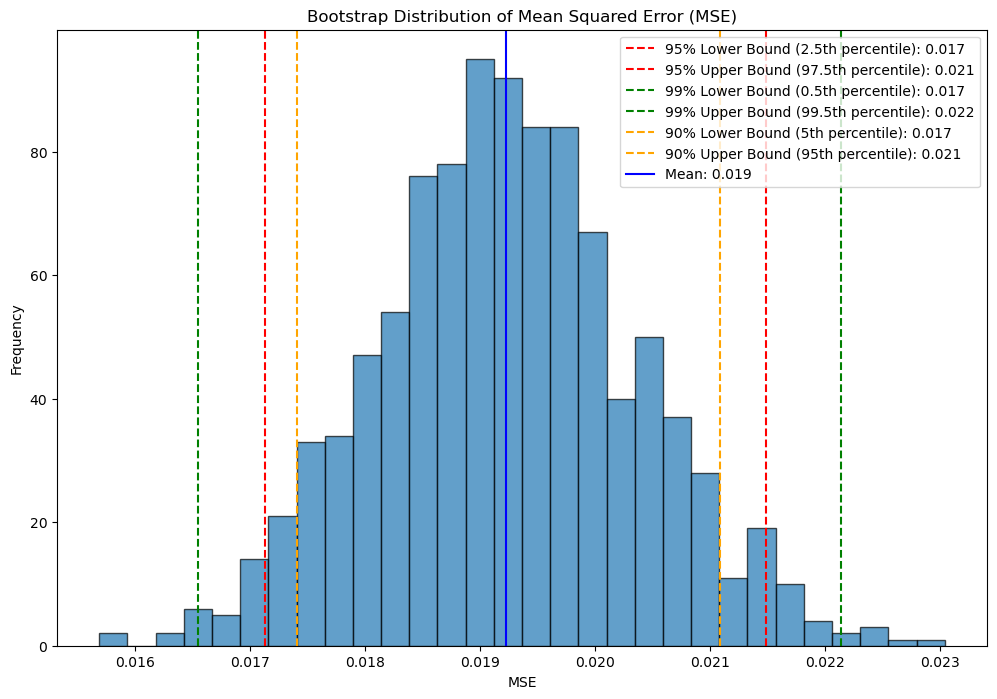

95% Confidence Interval for MSE: [0.017, 0.021]
99% Confidence Interval for MSE: [0.017, 0.022]
90% Confidence Interval for MSE: [0.017, 0.021]


In [173]:

# 90% CI, 95% CI, 99% CI
lower_bound_90 = np.percentile(bootstrap_metrics, 5)
upper_bound_90 = np.percentile(bootstrap_metrics, 95)

lower_bound_95 = np.percentile(bootstrap_metrics, 2.5)
upper_bound_95 = np.percentile(bootstrap_metrics, 97.5)

lower_bound_99 = np.percentile(bootstrap_metrics, 0.5)
upper_bound_99 = np.percentile(bootstrap_metrics, 99.5)


plt.figure(figsize=(12, 8))
plt.hist(bootstrap_metrics, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(lower_bound_95, color='red', linestyle='--', label=f'95% Lower Bound (2.5th percentile): {lower_bound_95:.3f}')
plt.axvline(upper_bound_95, color='red', linestyle='--', label=f'95% Upper Bound (97.5th percentile): {upper_bound_95:.3f}')
plt.axvline(lower_bound_99, color='green', linestyle='--', label=f'99% Lower Bound (0.5th percentile): {lower_bound_99:.3f}')
plt.axvline(upper_bound_99, color='green', linestyle='--', label=f'99% Upper Bound (99.5th percentile): {upper_bound_99:.3f}')
plt.axvline(lower_bound_90, color='orange', linestyle='--', label=f'90% Lower Bound (5th percentile): {lower_bound_90:.3f}')
plt.axvline(upper_bound_90, color='orange', linestyle='--', label=f'90% Upper Bound (95th percentile): {upper_bound_90:.3f}')
plt.axvline(np.mean(bootstrap_metrics), color='blue', linestyle='-', label=f'Mean: {np.mean(bootstrap_metrics):.3f}')
plt.title('Bootstrap Distribution of Mean Squared Error (MSE)')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"95% Confidence Interval for MSE: [{lower_bound_95:.3f}, {upper_bound_95:.3f}]")
print(f"99% Confidence Interval for MSE: [{lower_bound_99:.3f}, {upper_bound_99:.3f}]")
print(f"90% Confidence Interval for MSE: [{lower_bound_90:.3f}, {upper_bound_90:.3f}]")


The bootstrap analysis revealed that the linear regression model demonstrated a consistent and reliable performance in predicting the target variable, as indicated by the narrow range of the mean squared error across different confidence intervals. Specifically, the 95% confidence interval for the MSE was [0.017, 0.021], while the 99% interval extended slightly to [0.017, 0.022], showing a high degree of stability and low variability in model error across different resampled datasets. This indicates that the model generalizes well and maintains a stable error rate regardless of slight changes in the training data. The results suggest that the linear regression model is robust and reliable for predicting the target variable based on the selected features.